In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler,PowerTransformer
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from IPython.display import display


In [133]:
# Load dataset
df = pd.read_csv("creditcard.csv")
target_column = 'Class'
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove(target_column)
# Display dataset shape and first few rows
print(f"Dataset Shape: {df.shape}")
print("\nSample Rows:")
display(df.head())

Dataset Shape: (284807, 31)

Sample Rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [134]:
df_dtypes = pd.DataFrame(df.dtypes).reset_index()
df_dtypes.columns = ['Column', 'Data Type']
print(df_dtypes)

    Column Data Type
0     Time   float64
1       V1   float64
2       V2   float64
3       V3   float64
4       V4   float64
5       V5   float64
6       V6   float64
7       V7   float64
8       V8   float64
9       V9   float64
10     V10   float64
11     V11   float64
12     V12   float64
13     V13   float64
14     V14   float64
15     V15   float64
16     V16   float64
17     V17   float64
18     V18   float64
19     V19   float64
20     V20   float64
21     V21   float64
22     V22   float64
23     V23   float64
24     V24   float64
25     V25   float64
26     V26   float64
27     V27   float64
28     V28   float64
29  Amount   float64
30   Class     int64


In [135]:
# Detect skewed features
skewness_table = []  # List to store skewness values

print("Detecting skewed features...")
skewed_features = df[numerical_features].skew()
skewed_features = skewed_features[abs(skewed_features) > 0.5].index.tolist()
print(f"Skewed Features: {skewed_features}")
print(f"Skewness of V5: {df['V5'].skew()}")


Detecting skewed features...
Skewed Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']
Skewness of V5: -2.425901495952054


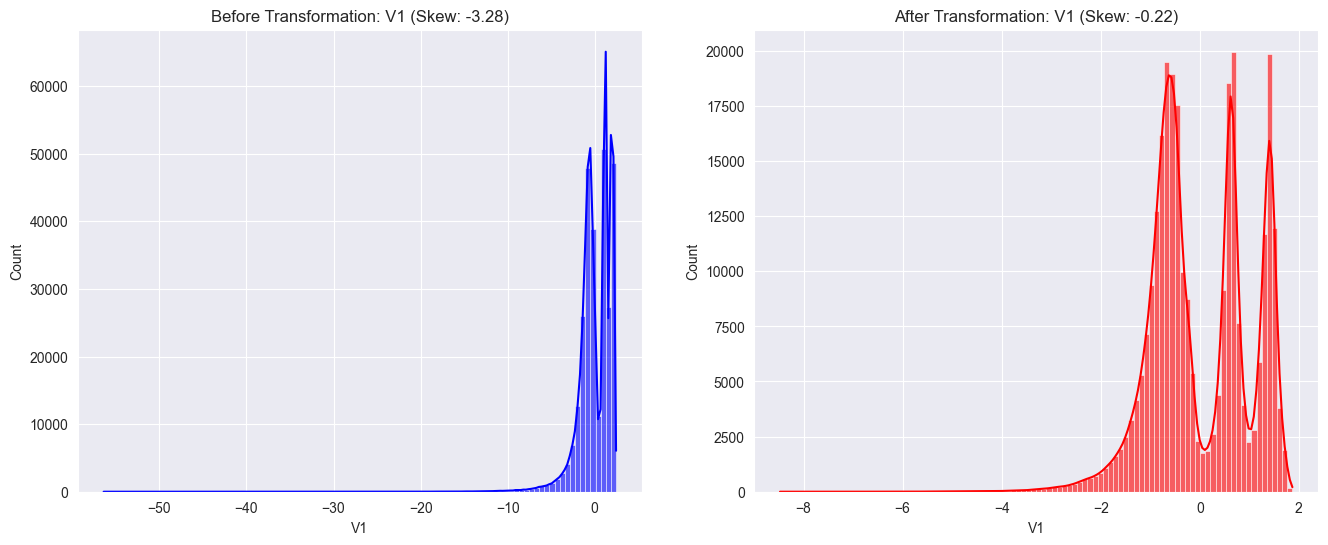

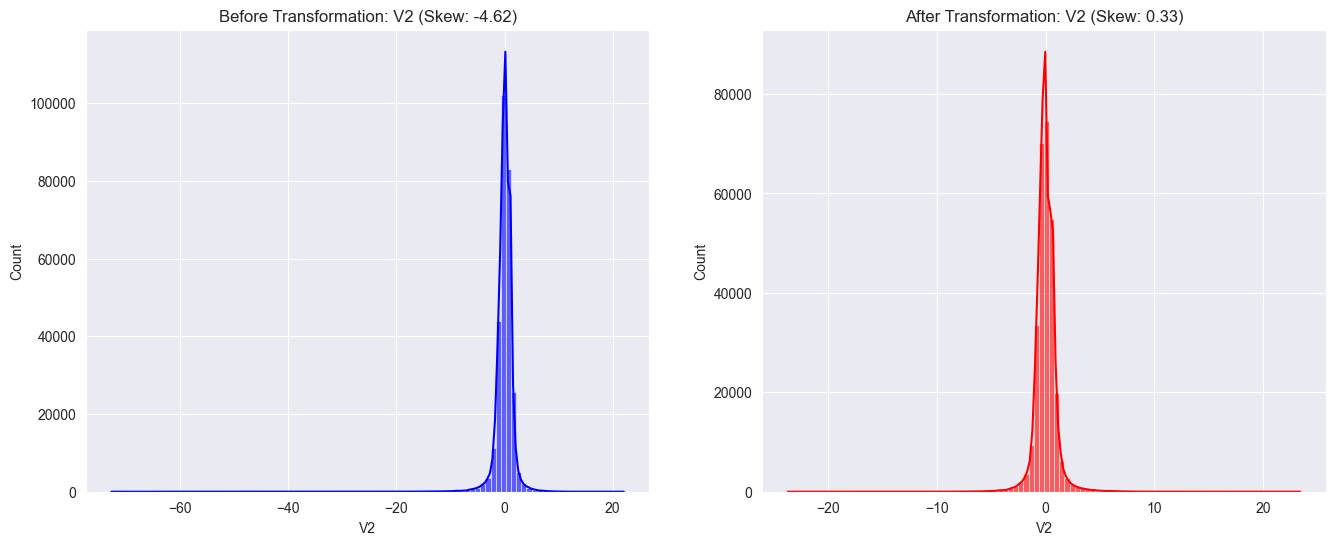

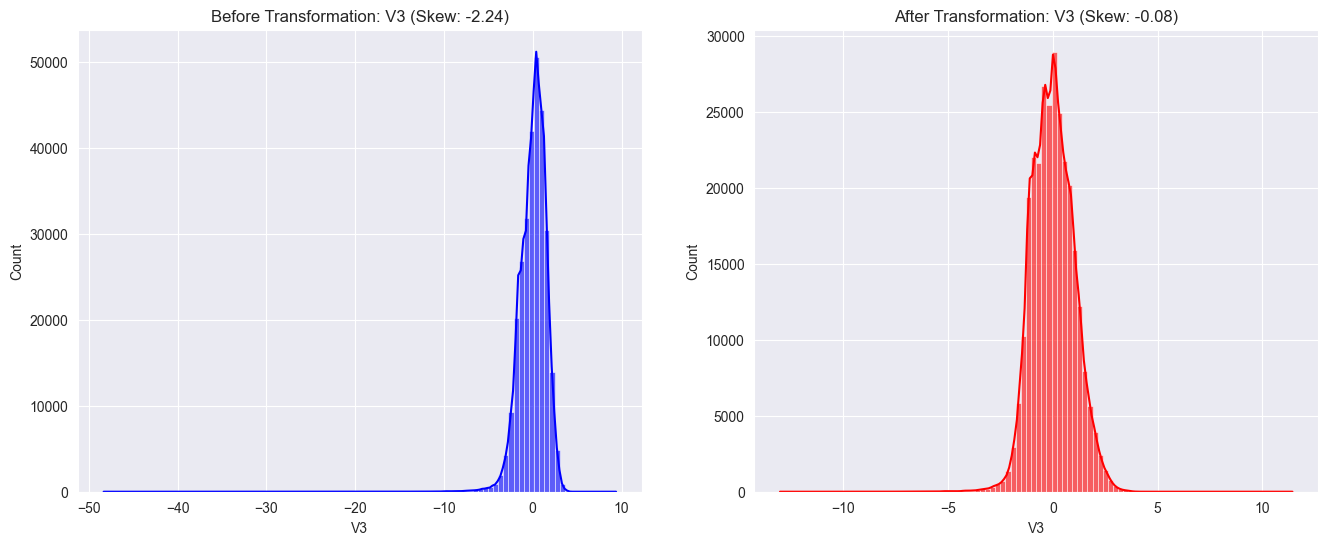

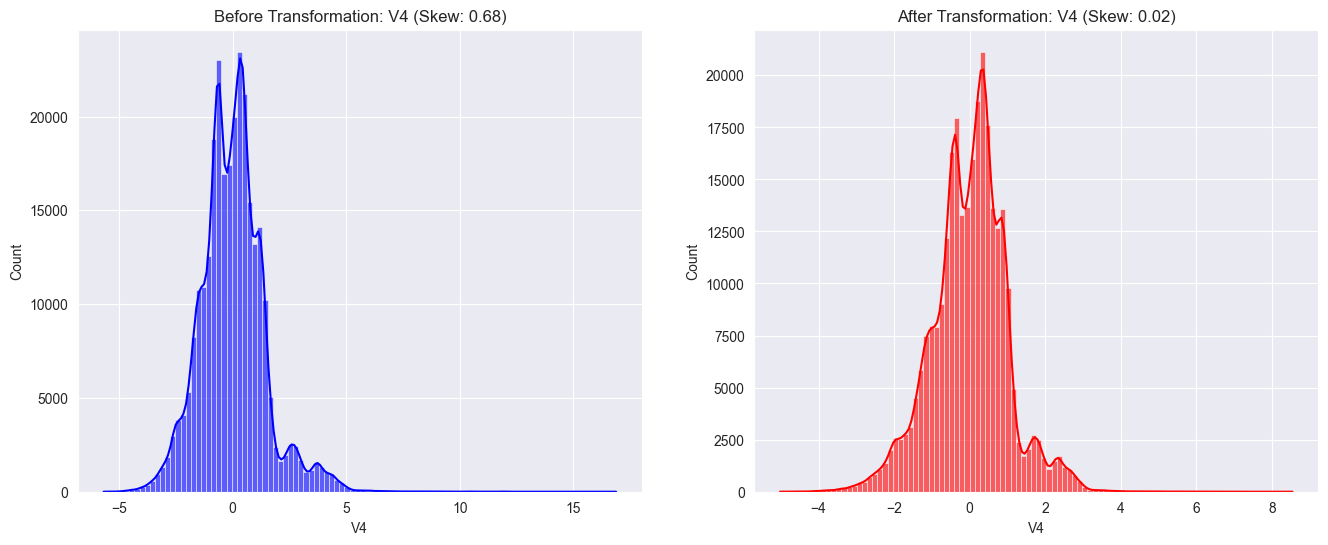

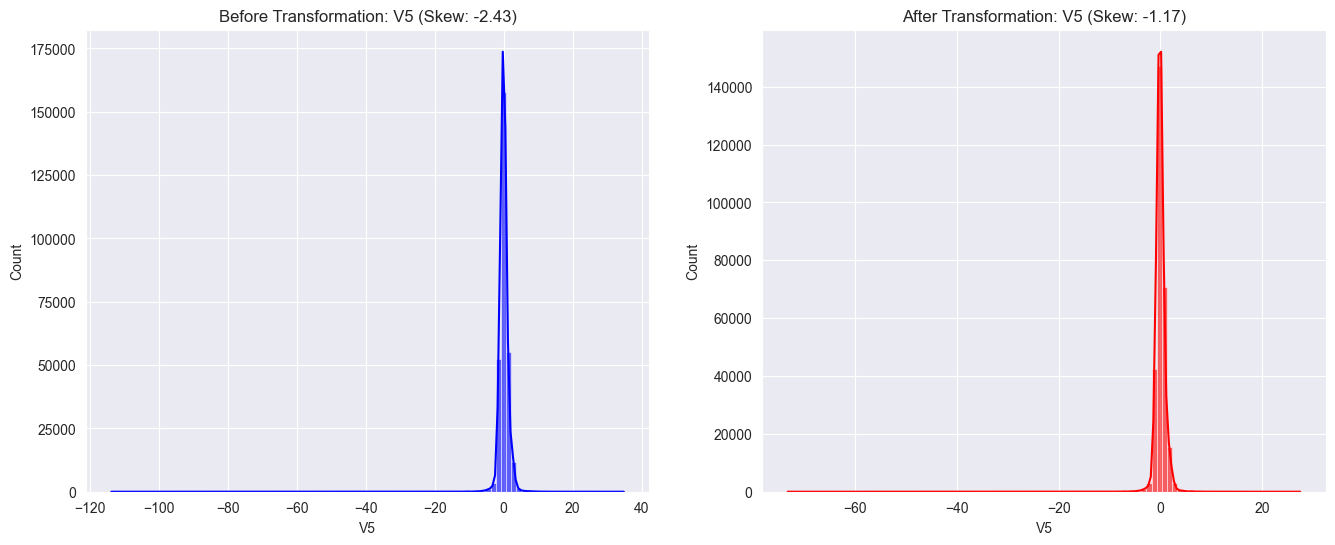

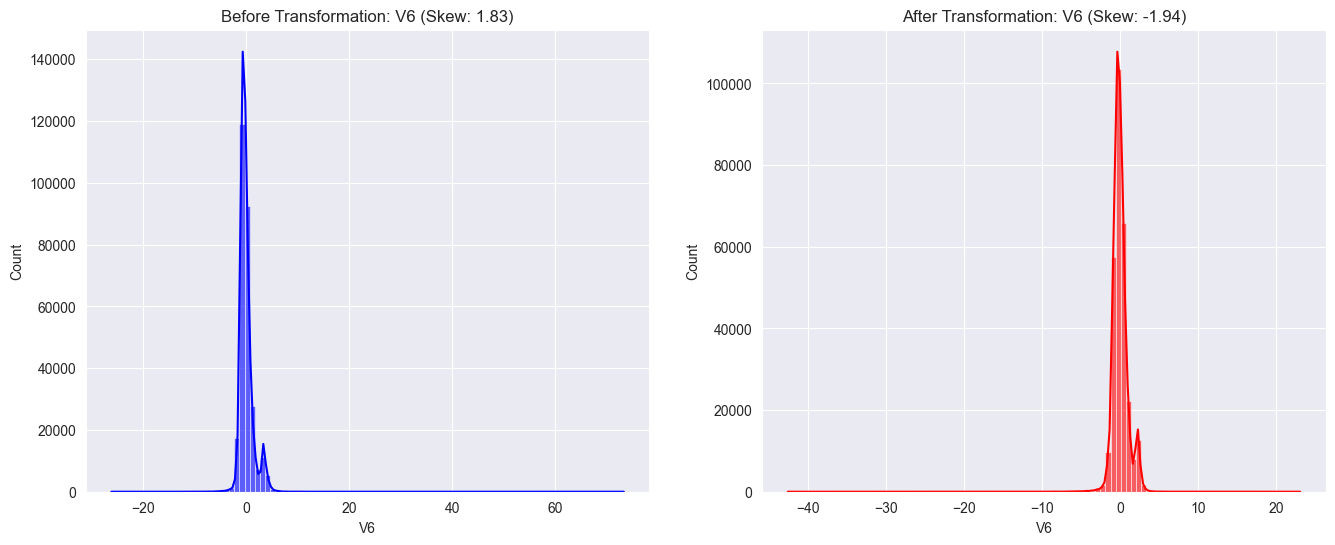

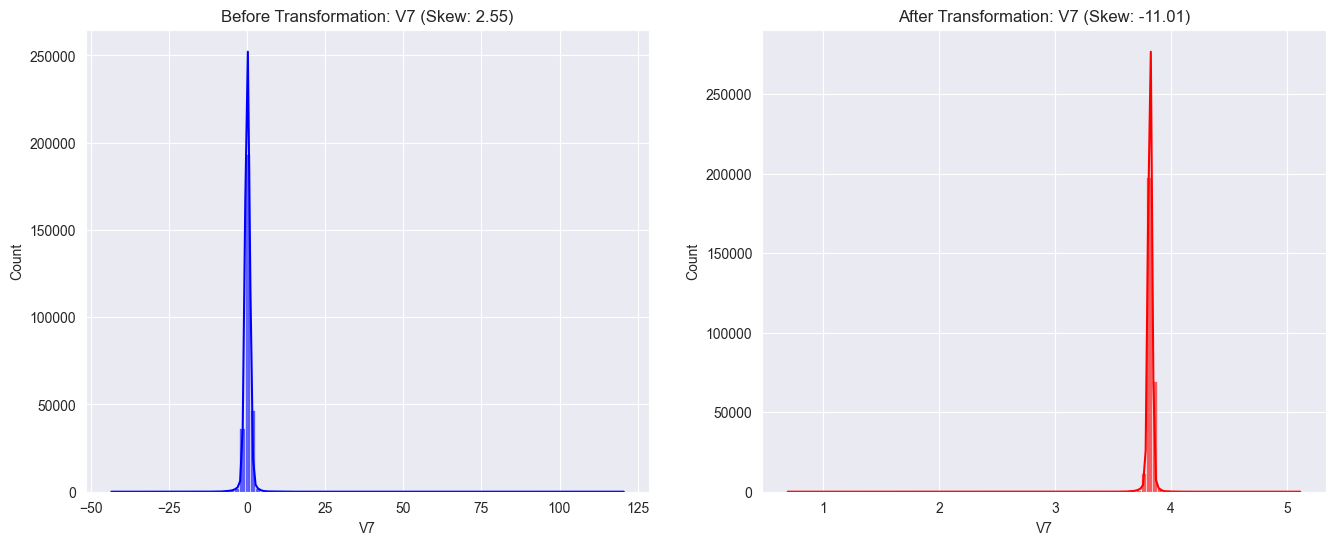

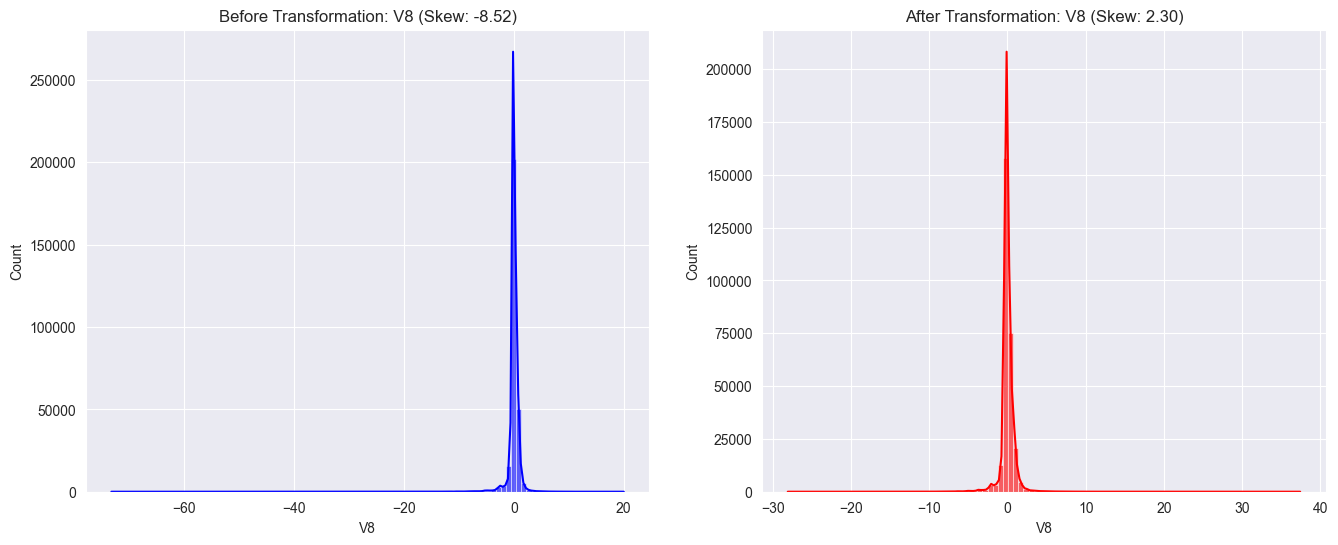

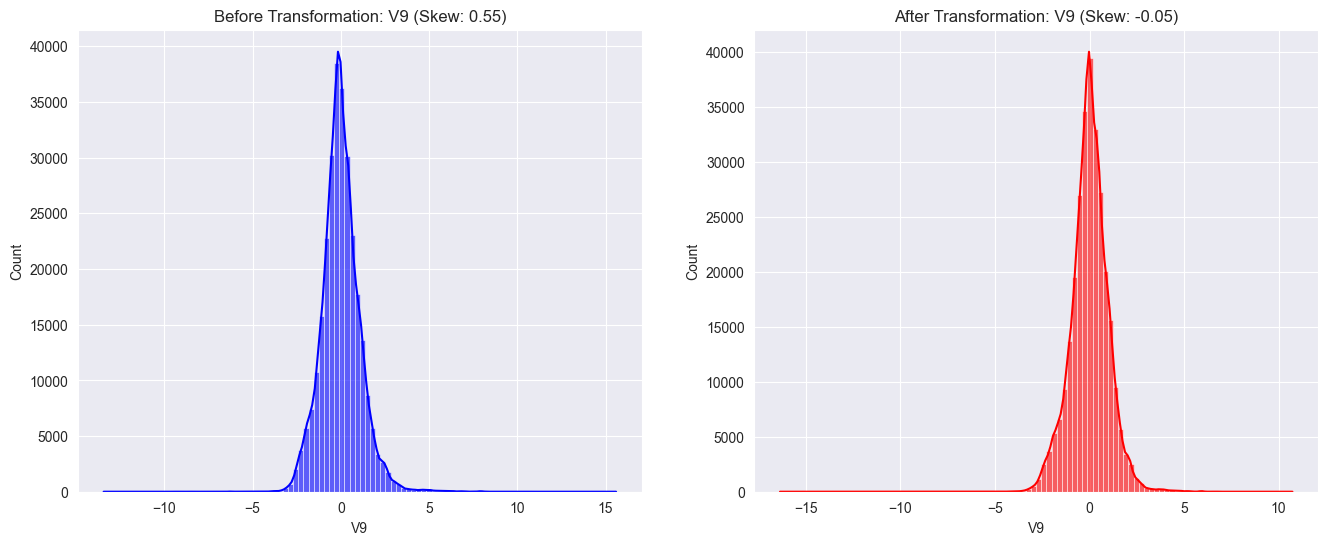

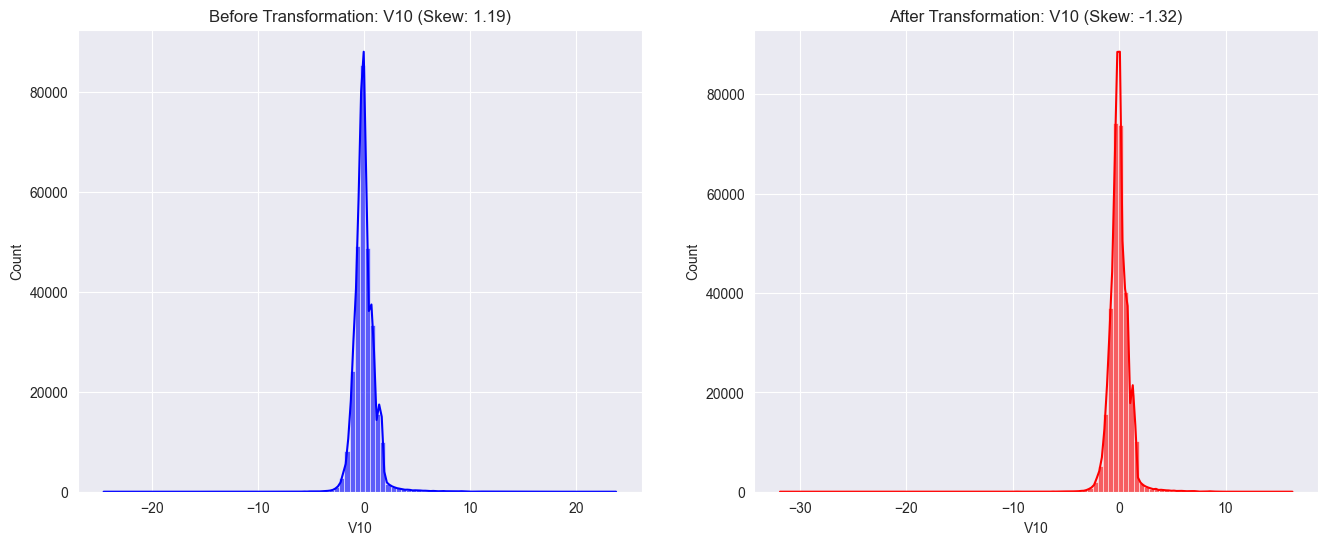

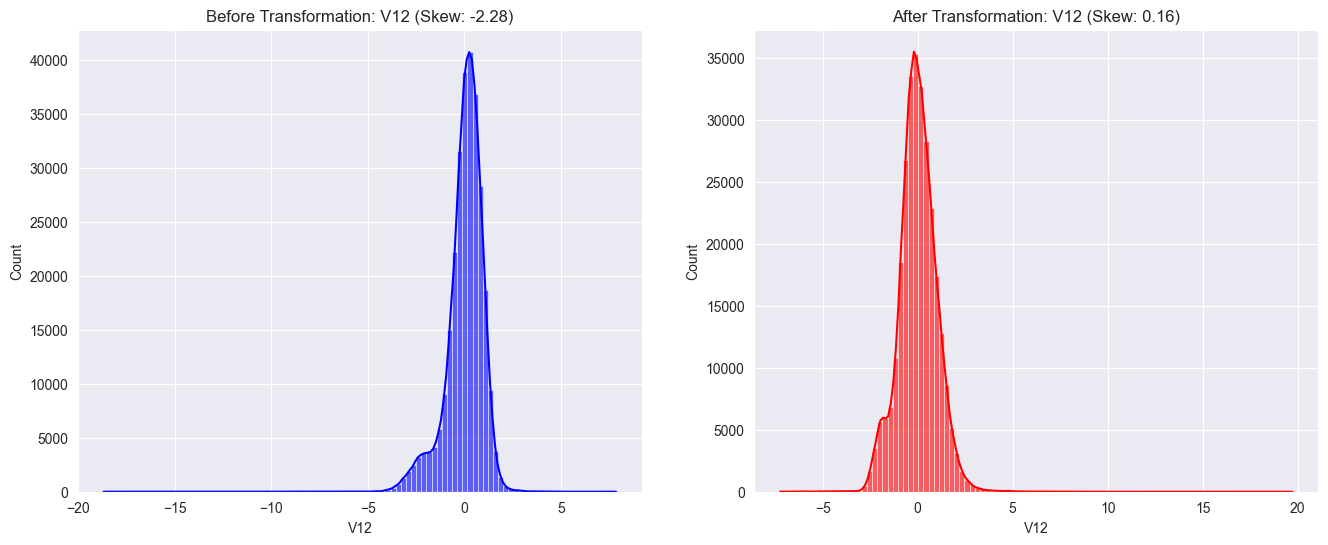

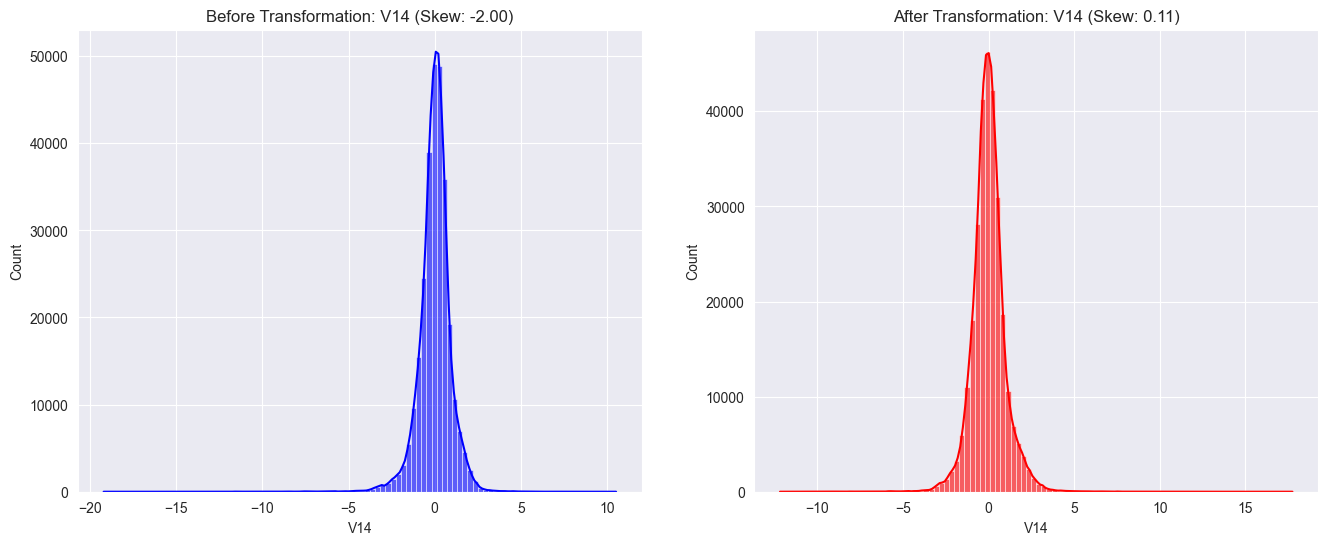

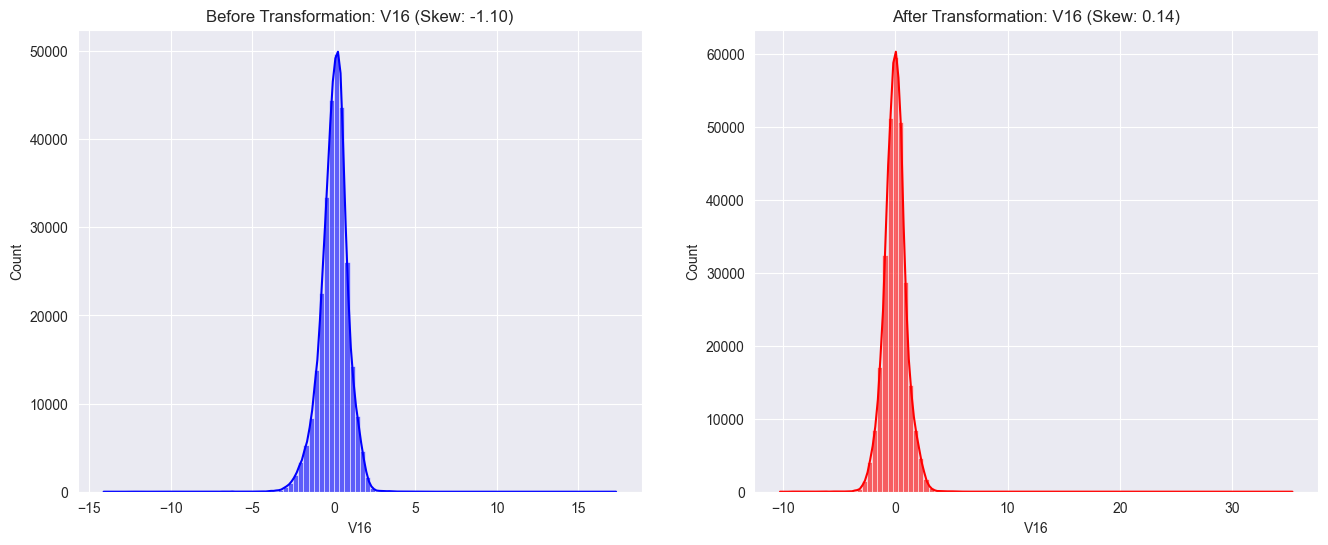

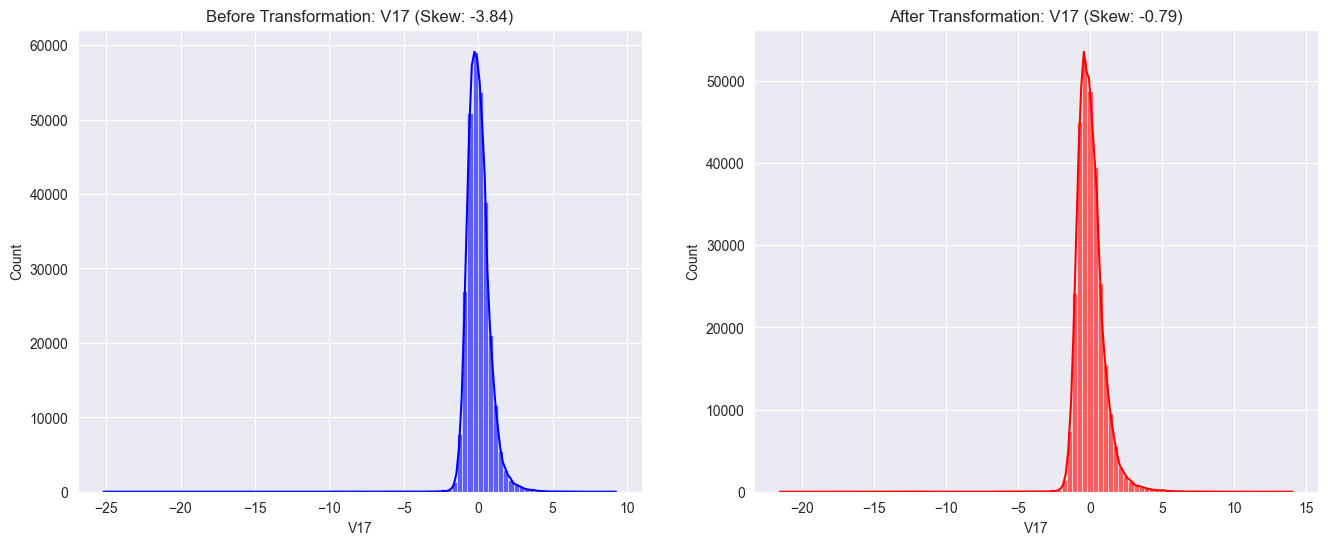

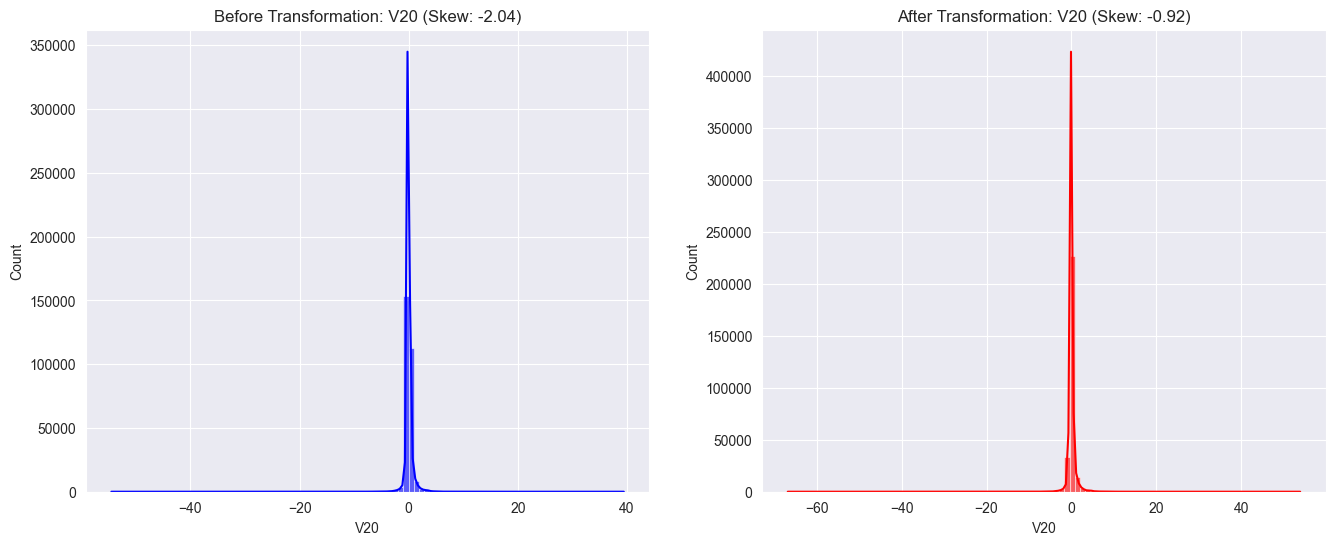

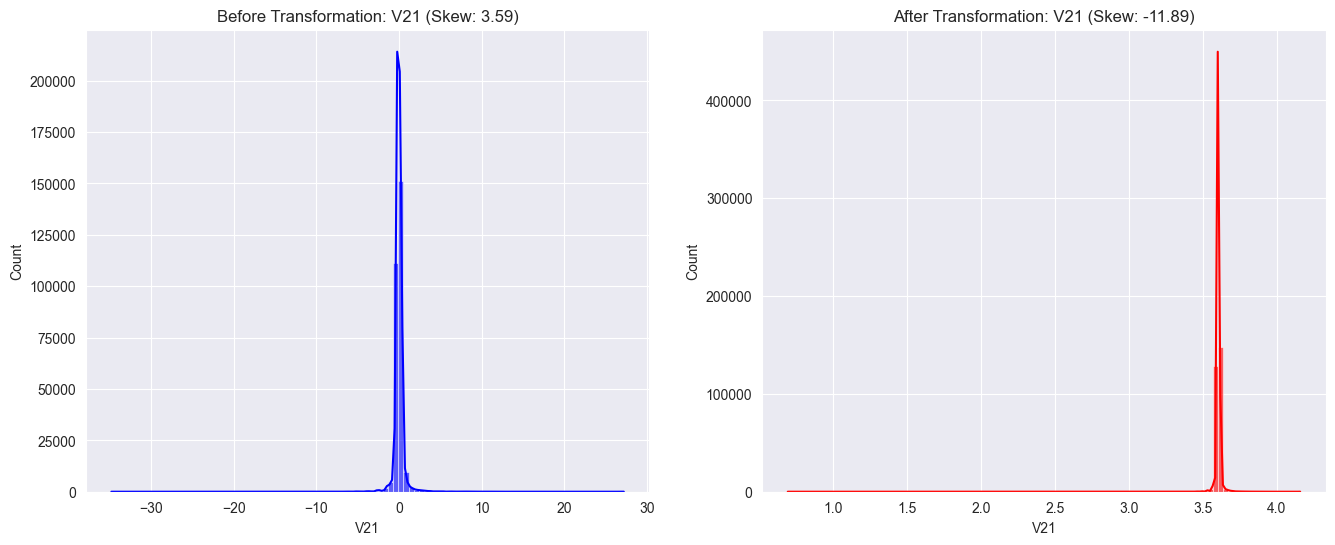

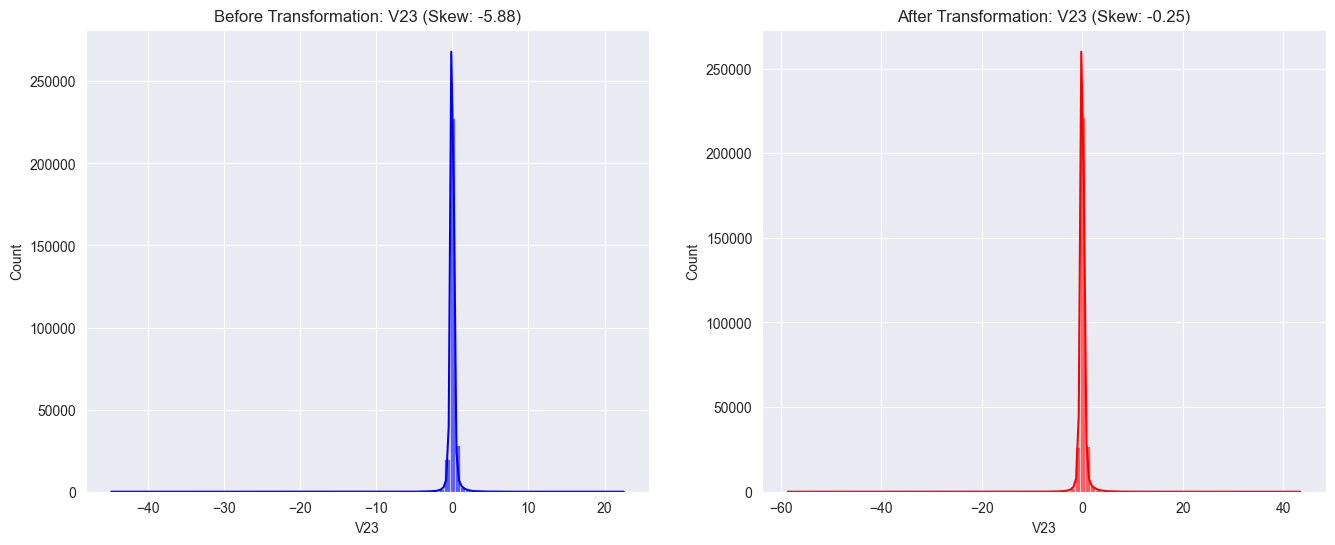

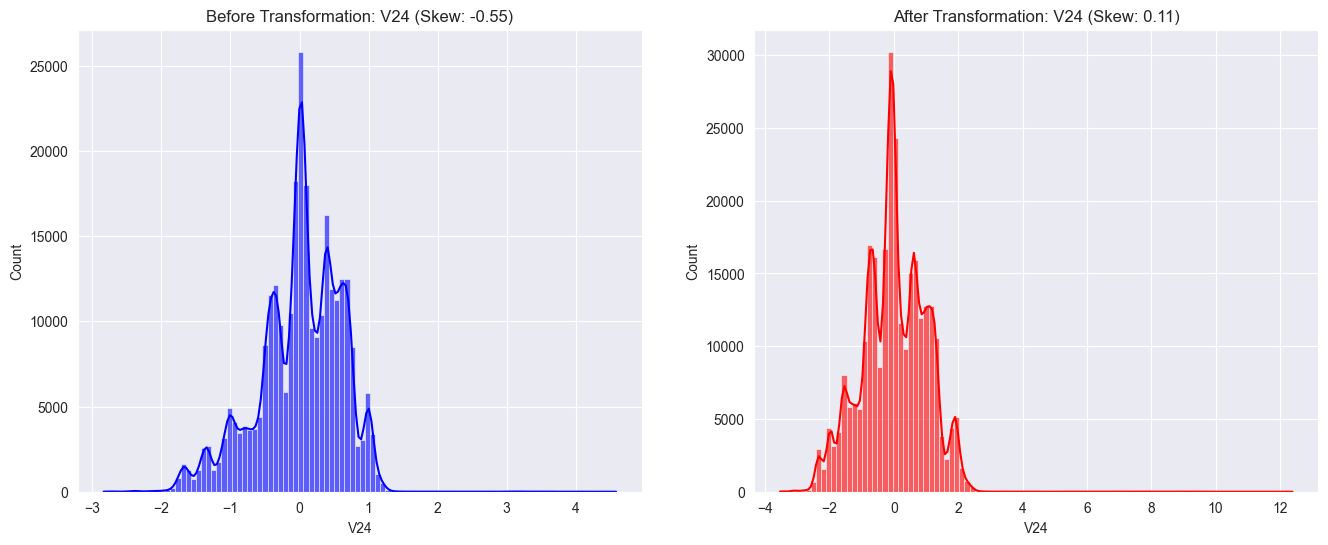

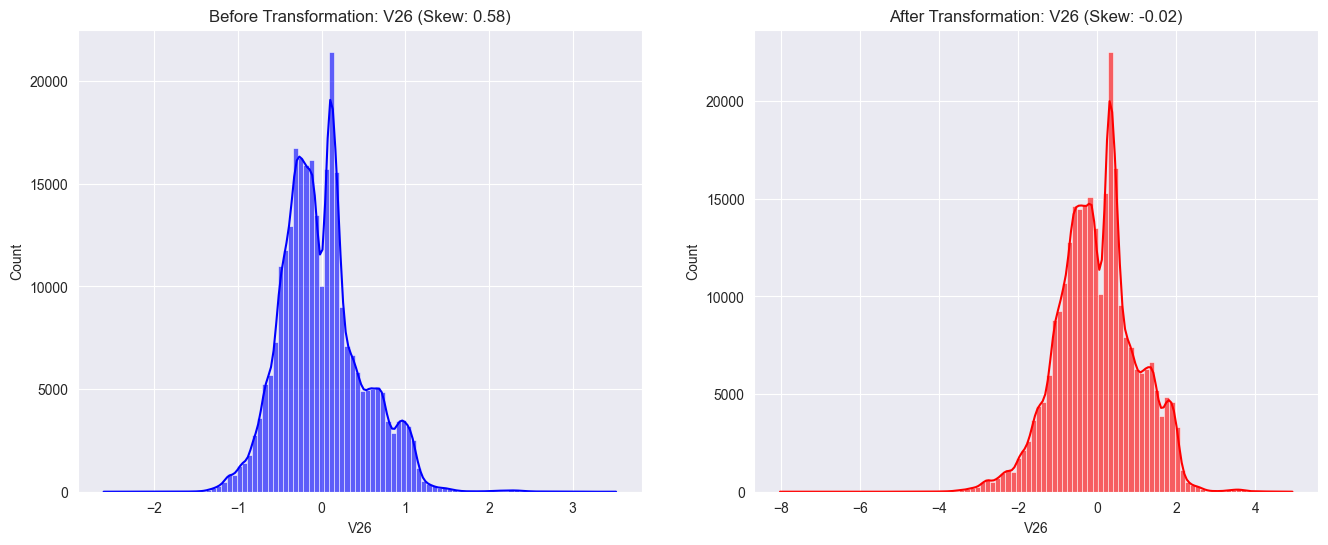

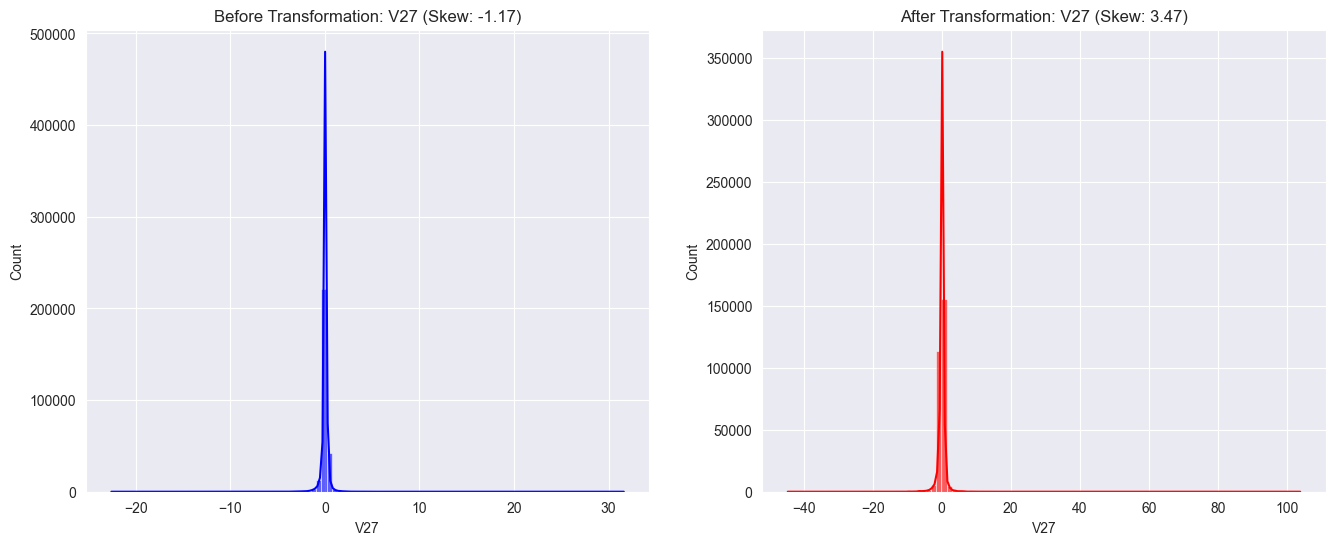

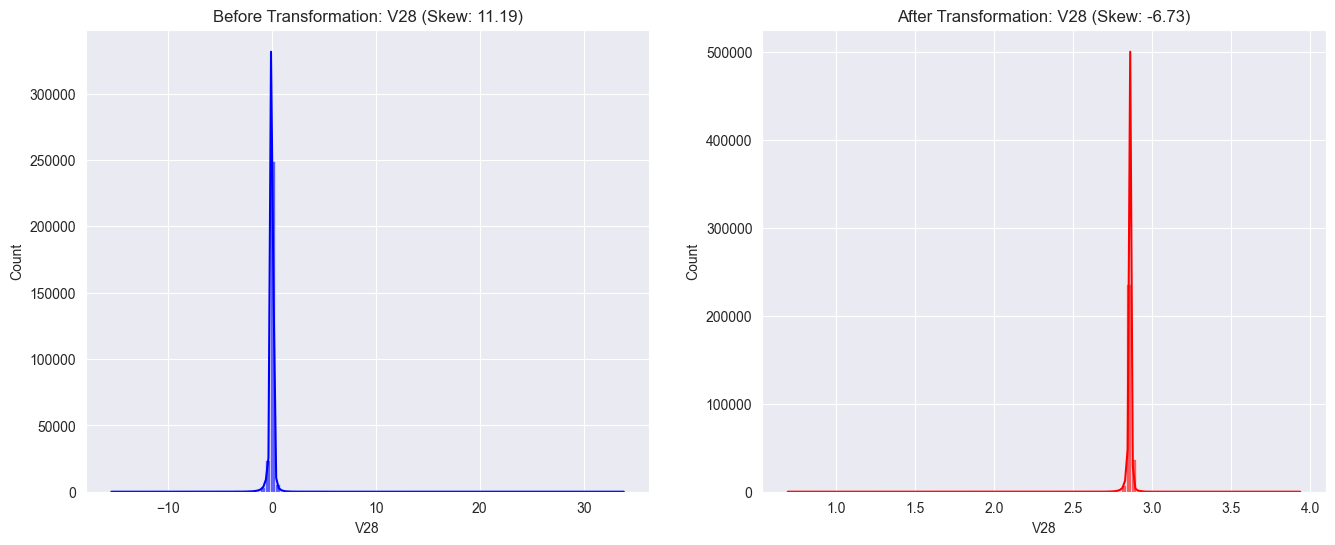

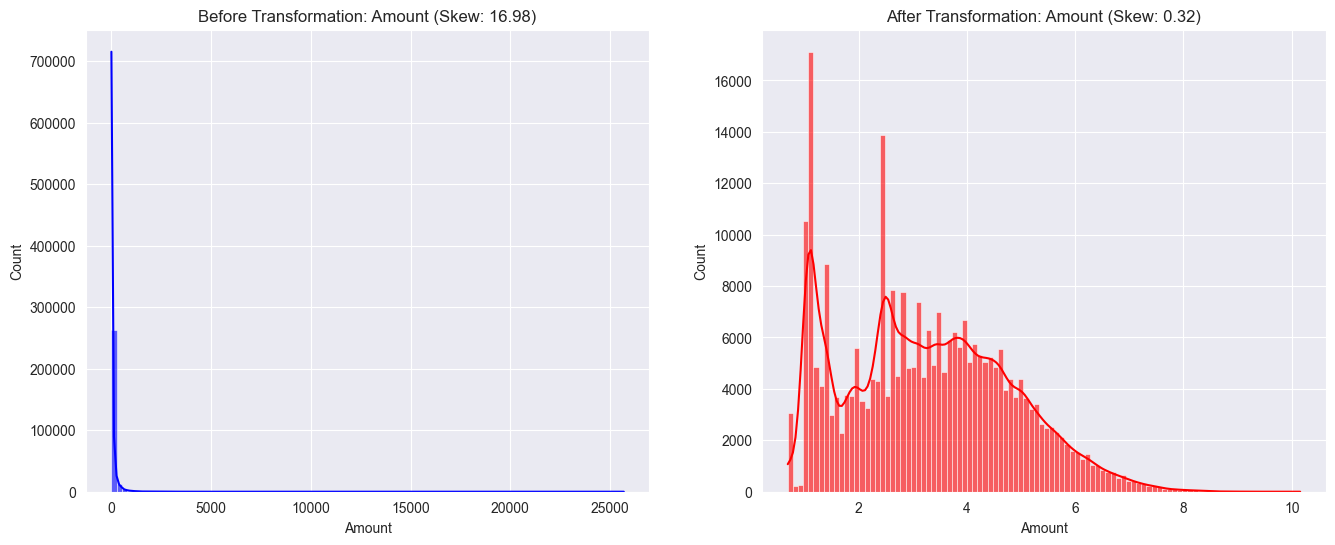

,Feature,Skewness Before,Skewness After
0,V1,-3.280667,-0.218003
1,V2,-4.624866,0.334852
2,V3,-2.240155,-0.079980
3,V4,0.676292,0.018930
4,V5,-2.425901,-1.170100
5,V6,1.826581,-1.937469
6,V7,2.553907,-11.007359
7,V8,-8.521944,2.297590
8,V9,0.554680,-0.048343
9,V10,1.187141,-1.318333


In [136]:
# Initialize skewness table
skewness_table = []

for feature in skewed_features:
    skew_before = df[feature].skew()  # Calculate skewness before transformation

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Wider figure size

    # Plot original distribution before transformation
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[0], color='blue', alpha=0.6)
    axes[0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f})')

    # Apply appropriate transformation
    if (df[feature] > 0).all():
        df[feature], _ = boxcox(df[feature] + 1)  # Box-Cox (Only for positive values)
    elif df[feature].skew() > 2:
        df[feature] = np.log1p(df[feature] - df[feature].min() + 1)  # Log Transform (Shifted)
    else:
        pt = PowerTransformer(method='yeo-johnson')
        df[feature] = pt.fit_transform(df[[feature]])  # Yeo-Johnson for general cases

    skew_after = df[feature].skew()  # Calculate skewness after transformation
    skewness_table.append([feature, skew_before, skew_after])  # Store values

    # Plot transformed distribution after transformation
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[1], color='red', alpha=0.6)
    axes[1].set_title(f'After Transformation: {feature} (Skew: {skew_after:.2f})')

    plt.show()

# Convert skewness table to DataFrame and display it
skewness_df = pd.DataFrame(skewness_table, columns=["Feature", "Skewness Before", "Skewness After"])
display(skewness_df)


In [137]:
# Standardize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [138]:
# Convert skewness table to DataFrame
skewness_df = pd.DataFrame(skewness_table, columns=["Feature", "Skewness Before", "Skewness After"])

# Display the table
from IPython.display import display
display(skewness_df)


,Feature,Skewness Before,Skewness After
0,V1,-3.280667,-0.218003
1,V2,-4.624866,0.334852
2,V3,-2.240155,-0.079980
3,V4,0.676292,0.018930
4,V5,-2.425901,-1.170100
5,V6,1.826581,-1.937469
6,V7,2.553907,-11.007359
7,V8,-8.521944,2.297590
8,V9,0.554680,-0.048343
9,V10,1.187141,-1.318333


Checking class balance...


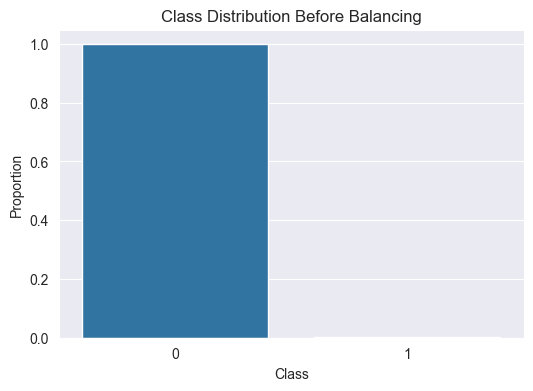

Class Distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [139]:
# Check class balance
print("Checking class balance...")
class_counts = df[target_column].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()
print("Class Distribution:")
print(class_counts)


In [140]:
# Balance classes using SMOTE
print("Applying SMOTE for class balancing...")
X = df.drop(columns=[target_column])
y = df[target_column]
sampler = SMOTE()
X_resampled, y_resampled = sampler.fit_resample(X, y)
df = pd.DataFrame(X_resampled, columns=X.columns)
df[target_column] = y_resampled

Applying SMOTE for class balancing...


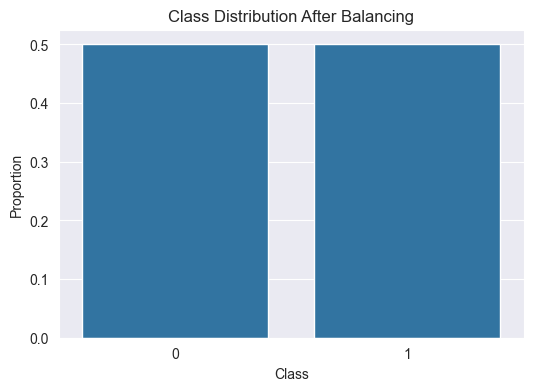

Class Distribution After Balancing:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64
Preprocessing complete.


In [141]:
# Show class balance after resampling
class_counts = df[target_column].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()
class_counts_after = df[target_column].value_counts(normalize=True)

print("Class Distribution After Balancing:")
print(class_counts_after)

print("Preprocessing complete.")
